In [37]:
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import numpy as np
import os
import shutil
import xml.etree.ElementTree as ET
import xmltodict

In [30]:
images = os.listdir("data/images/") 

In [31]:
df = pd.DataFrame(images, columns =['image_name'])

In [49]:
def get_paths(row):
    image_name = row["image_name"]
    id         = image_name.split(".")[0]
    image_path = os.path.abspath(f"./data/images/{id}.PNG")
    label_path = os.path.abspath(f"./data/labels/{id}.xml")
    row["image_path"] = image_path
    row["label_path"] = label_path
    row['id'] = id
    return row

In [50]:
df = df.apply(get_paths, axis = 1)

In [51]:
df.head(2)

,image_name,image_path,label_path,id
0,00001.PNG,c:\Users\Abhishek pandir\ML\Table Detection\da...,c:\Users\Abhishek pandir\ML\Table Detection\da...,00001
1,00005.PNG,c:\Users\Abhishek pandir\ML\Table Detection\da...,c:\Users\Abhishek pandir\ML\Table Detection\da...,00005


In [55]:
df.columns

Index(['image_name', 'image_path', 'label_path', 'id'], dtype='object')

In [58]:
def read_xml(path_to_xml):
    xml_data  = open(path_to_xml).read() #
    xml_dict  = xmltodict.parse(xml_data)
    return xml_dict

def parse_xml_dict(row):
    path_to_xml = row['label_path']
    xml_dict  = read_xml(path_to_xml)
    # get image dimension 
    image_dimension = xml_dict['annotation']['size']
    # get image_height and image_width
    row['image_height'] = int(image_dimension['height'])
    row['image_width'] = int(image_dimension['width'])

    # get numbounding boxes
    objects = xml_dict['annotation']['object']
    if isinstance(objects,list):
        row['num_objects'] = len(objects)
    else:
        row['num_objects'] = 1 
        objects  = [objects]
    # get bounding boxes
    bounding_boxes = [] #
    for object in objects:
        bbox = object['bndbox']
        bounding_boxes.append([int(bbox['xmin']),int(bbox['ymin']),int(bbox['xmax']),int(bbox['ymax'])])
    row['bounding_boxes'] = bounding_boxes
    return row

In [59]:
df = df.apply(parse_xml_dict, axis = 1)

In [64]:
training_directory = os.path.join(os.getcwd(), "yolo_cache")

if not os.path.exists(training_directory):
    os.makedirs(training_directory)

train_image_directory =os.path.join(training_directory, "images/")
if not os.path.exists(train_image_directory):
    os.makedirs(train_image_directory)

train_label_directory = os.path.join(training_directory, "labels/")
if not os.path.exists(train_label_directory):
    os.makedirs(train_label_directory)



In [65]:
df['yolo_image_path']=df['id'].apply(lambda x: os.path.join(train_image_directory,f"{x}.PNG"))
df['yolo_label_path']=df['id'].apply(lambda x: os.path.join(train_label_directory,f"{x}.txt"))

In [66]:
temp =df.apply(lambda x: shutil.copy(x['image_path'],x['yolo_image_path']), axis= 1)

In [67]:
df.columns

Index(['image_name', 'image_path', 'label_path', 'id', 'image_height',
       'image_width', 'num_objects', 'bounding_boxes', 'yolo_image_path',
       'yolo_label_path'],
      dtype='object')

In [68]:

from tqdm.notebook import tqdm 
from utils.bounding_box import voc_to_yolo
cnt = 0
all_bboxes = []
for row_idx in tqdm(range(df.__len__())):
    row = df.iloc[row_idx]
    image_height = row.image_height
    image_width  = row.image_width
    bboxes_coco  = np.array(row['bounding_boxes']).astype(np.float32).copy()
    num_bbox     = row.num_objects
    names        = ['tabel']*num_bbox
    labels       = [0]*num_bbox
    ## Create Annotation(YOLO)
    with open(row.yolo_label_path, 'w') as f:
        if num_bbox<1:
            annot = ''
            f.write(annot)
            cnt+=1
            continue
        bboxes_yolo  = voc_to_yolo(image_height, image_width, bboxes_coco)
        bboxes_yolo  = np.clip(bboxes_yolo, 0, 1)
        all_bboxes.extend(bboxes_yolo)
        for bbox_idx in range(len(bboxes_yolo)):
            annot = [str(labels[bbox_idx])]+ list(bboxes_yolo[bbox_idx].astype(str))+(['\n'] if num_bbox!=(bbox_idx+1) else [''])
            annot = ' '.join(annot)
            annot = annot.strip(' ')
            f.write(annot)
print('Missing:',cnt)


Missing: 0


<AxesSubplot:ylabel='Frequency'>

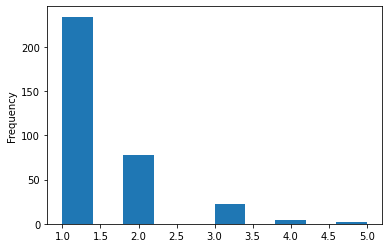

In [69]:
df.num_objects.plot(kind="hist")

In [70]:
train = df[:300]
val   = df[300:]

In [72]:
import yaml

train_txt_path = os.path.abspath(os.path.join(training_directory, 'train.txt'))
with open(train_txt_path, 'w') as f:
    for path in train.yolo_image_path.tolist():
        f.write(path+'\n')
val_txt_path = os.path.abspath(os.path.join(training_directory, 'val.txt'))            
with open(val_txt_path, 'w') as f:
    for path in val.yolo_label_path.tolist():
        f.write(path+'\n')

In [73]:
data = dict(
    path  = os.getcwd(),
    train =  train_txt_path,
    val   =  val_txt_path,
    nc    = 1,
    names = ['table'],
    )
with open(os.path.join( os.getcwd() , 'yolo.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(os.path.join( os.getcwd() , 'yolo.yaml'), 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- table
nc: 1
path: c:\Users\Abhishek pandir\ML\Table Detection
train: c:\Users\Abhishek pandir\ML\Table Detection\yolo_cache\train.txt
val: c:\Users\Abhishek pandir\ML\Table Detection\yolo_cache\val.txt

